# Gaussian Actor-Critic Example

##### Imports

In [1]:
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)

In [2]:
import numpy as np
import torch
from torch import nn, optim
from tqdm import tqdm
from kilroyplot.plot import plt
from kilroyshare.codec import Codec
from kilroytorch.modules.offline.gaussian import SimpleGaussianOfflineModule as OfflineModule
from kilroytorch.modules.online.continuous import ActorCriticContinuousOnlineModule as OnlineModule
from kilroytorch.models.distribution.gaussian import LinearGaussianDistributionModel as DistributionModel
from kilroytorch.models.reward.continuous import NonLinearContinuousRewardModel as RewardModel

##### Helpers

In [3]:
def chunks(data, size):
    for i in range(0, len(data), size):
        yield data[i:i + size]

def generate(model, codec, n):
    return [codec.encode(sample) for sample in model.sample(n)[0]]

## Task

Let's assume the values of the score function for all classes are like shown below.

In [4]:
score = lambda value: -(value-10)**2 + np.random.randn() * 20  # sine plus some noise

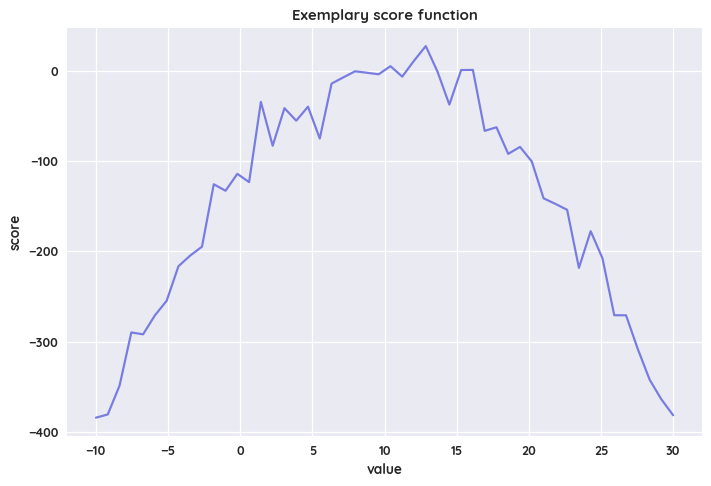

In [5]:
xs = np.linspace(-10, 30)
plt.plot(xs, [score(x) for x in xs])
plt.title("Exemplary score function")
plt.xlabel("value")
plt.ylabel("score")
plt.tight_layout()

## Model

In [6]:
class DummyCodec(Codec):
    def encode(self, value):
        return value.item()

    def decode(self, value):
        return torch.as_tensor(value)

In [7]:
actor = DistributionModel()
critic = RewardModel()
codec = DummyCodec()
offline_module = OfflineModule(
    actor, 
    codec, 
    optim.Adam(actor.parameters(), lr=0.1)
)
online_module = OnlineModule(
    actor, 
    critic, 
    codec, 
    (optim.Adam(actor.parameters(), lr=0.01), optim.Adam(critic.parameters(), lr=0.01)),
    actor_iterations=100
)

## Offline

Let's assume real samples are distributed normally.

In [8]:
n_samples = 1000
samples = np.random.normal(0, 8, n_samples)

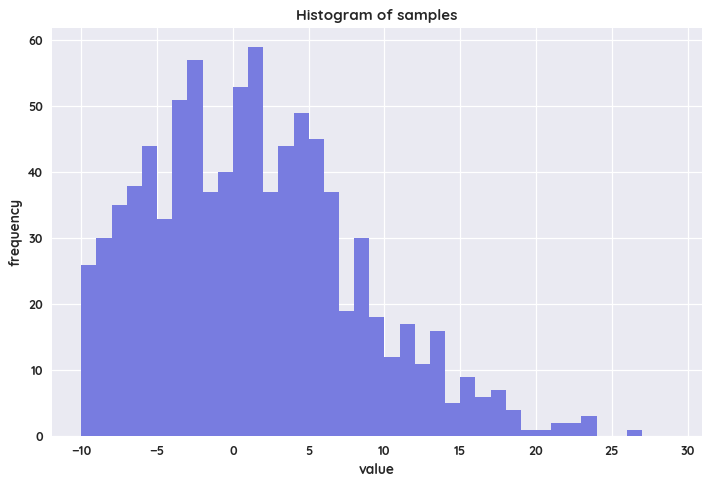

In [9]:
xs = np.linspace(-10, 30)
plt.hist(samples, bins=np.arange(-10, 30))
plt.title("Histogram of samples")
plt.xlabel("value")
plt.ylabel("frequency")
plt.tight_layout()

In [10]:
n_epochs = 100
batch_size = 512
losses = []

for _ in tqdm(range(n_epochs)):
    epoch_losses = []
    for batch in chunks(samples, batch_size):
        metrics = offline_module.fit(batch)
        epoch_losses.append(metrics["loss"])
        offline_module = offline_module.step()
    losses.append(np.mean(epoch_losses))

100%|██████████| 100/100 [00:00<00:00, 141.91it/s]


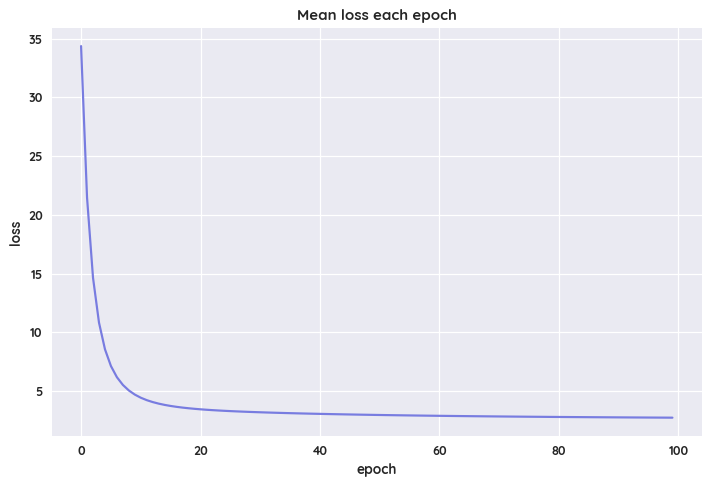

In [11]:
plt.plot(losses)
plt.title("Mean loss each epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.tight_layout()

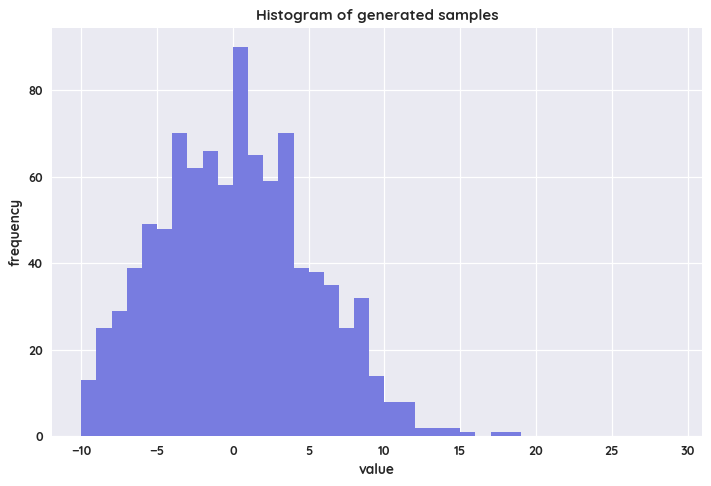

In [12]:
plt.hist(generate(actor, codec, 1000), bins=np.arange(-10, 30))
plt.title("Histogram of generated samples")
plt.xlabel("value")
plt.ylabel("frequency")
plt.tight_layout()

## Online

In [13]:
n_iters = 1000
iter_size = 32
critic_losses = []
actor_losses = []
mean_scores = []

for _ in tqdm(range(n_iters)):
    scores = {
        key: score(value) for key, value in online_module.sample(iter_size)
    }
    mean_scores.append(np.mean(list(scores.values())))
    metrics = online_module.fit(scores)
    critic_losses.append(metrics["critic_loss"])
    actor_losses.append(metrics["actor_loss"])
    online_module = online_module.step()

100%|██████████| 1000/1000 [01:01<00:00, 16.23it/s]


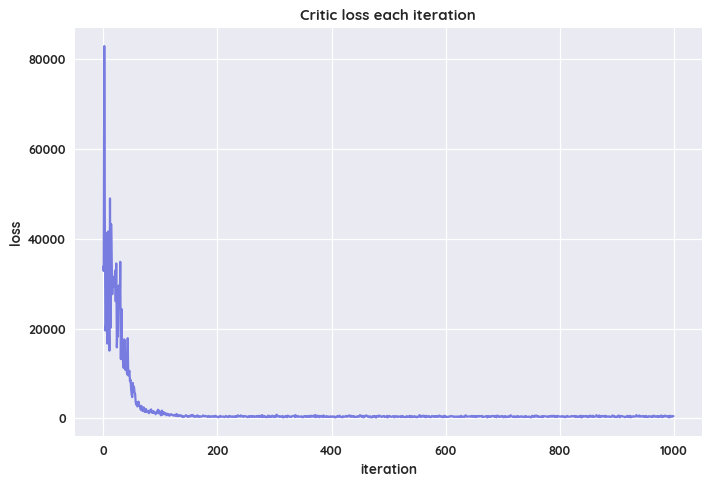

In [14]:
plt.plot(critic_losses)
plt.title("Critic loss each iteration")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.tight_layout()

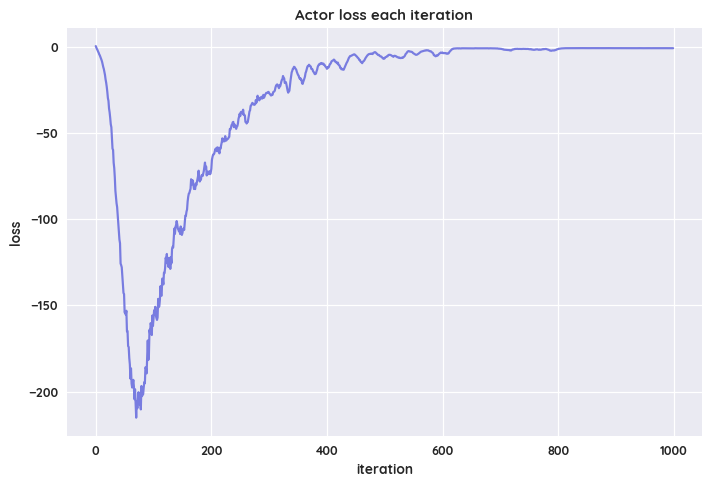

In [15]:
plt.plot(actor_losses)
plt.title("Actor loss each iteration")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.tight_layout()

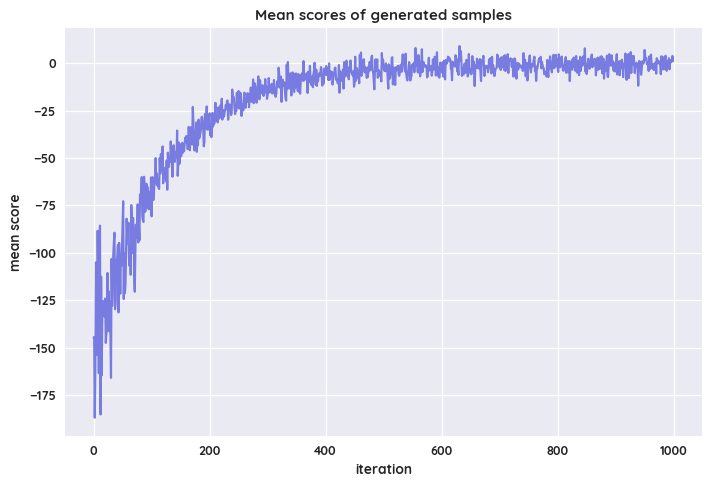

In [16]:
plt.plot(mean_scores)
plt.title("Mean scores of generated samples")
plt.xlabel("iteration")
plt.ylabel("mean score")
plt.tight_layout()

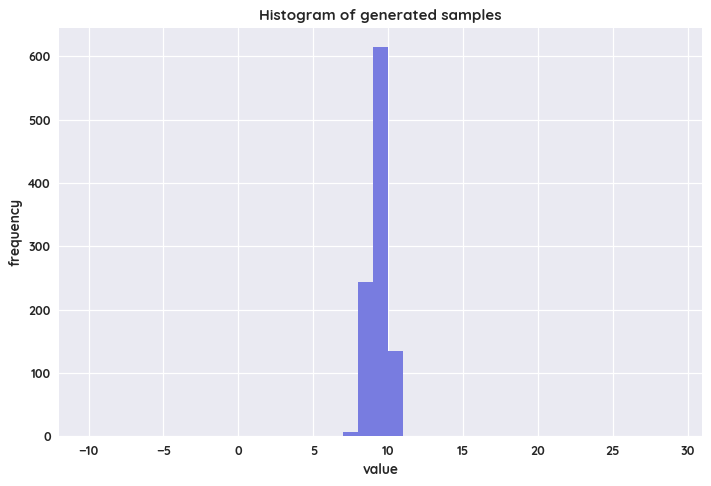

In [17]:
plt.hist(generate(actor, codec, 1000), bins=np.arange(-10, 30))
plt.title("Histogram of generated samples")
plt.xlabel("value")
plt.ylabel("frequency")
plt.tight_layout()

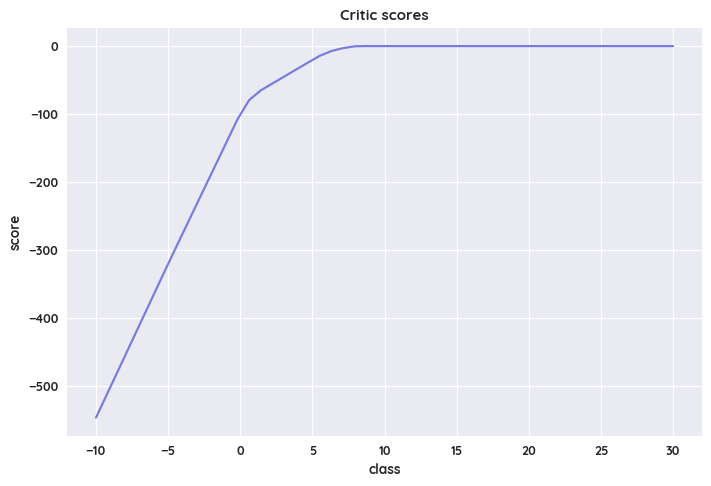

In [18]:
xs = np.linspace(-10, 30)
plt.plot(xs, critic(torch.tensor(xs).float().view(-1, 1)).detach().flatten().numpy())
plt.title("Critic scores")
plt.xlabel("class")
plt.ylabel("score")
plt.tight_layout()